# III. Filter data using Cordoni's algorithm

> Francisco Carrasco Varela - Pontificia Universidad Católica de Chile (PUC) - ffcarrasco@uc.cl ⭐

<center>
<mark>The following Jupyter Notebook is used to extract and work with Gaia DR3 data<br>
    (and other data releases) </mark>
</center>

In [93]:
# Import all the libraries we will need

%matplotlib inline
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import numpy as np
import os
from astropy.io import ascii
from astropy.table import vstack, Table
from tabulate import tabulate

import sys
sys.path.insert(0, '../Scripts/')
import Parameters as PR

In [5]:
# Get data from Vasiliev (2019) file

###################################################
object_name = "NGC104"  # <--- OBJECT NAME FROM PREVIOUS STEPS, EDITABLE
vasiliev_file = "../ObservedData/Vasiliev_2019_Gaia_parameters.dat"
###################################################


data_list = PR.get_GC_params(vasiliev_file)
obj, success = PR.get_selected_GC(object_name, data_list)

if success:
    n_times = 60
    print("Object detected succesfully!")
    print("-"*n_times)
    print(f"Object name: {obj.name}")
    print(f"Mean Proper Motion RA (mas/yr): {obj.pm_RA} +- {obj.err_pm_RA}")
    print(f"Mean Proper Motion DEC (mas/yr): {obj.pm_DEC} +- {obj.err_pm_DEC}")
    print("-"*n_times)

Object detected succesfully!
------------------------------------------------------------
Object name: NGC104
Mean Proper Motion RA (mas/yr): 5.237 +- 0.039
Mean Proper Motion DEC (mas/yr): -2.524 +- 0.039
------------------------------------------------------------


In [8]:
def check_if_file_exists(filename_path: str) -> None:
    """
    Checks if a file with filtered data that should have been created in the previous step
    of this Notebook is created. If it is not created it will exit the program.
    You should run the previous step of this Notebook then.
    """
    isExist = os.path.exists(filename_path)
    if not isExist:
        print(f"Warning! {filename_path} file not found.")
        print("You must fully run the previous step in this Notebook and create a file with ", end='')
        print("filtered data before running this cell.")
        sys.exit("Create filtered file in previous Notebook step and retry.")
    return

dir_path = f"../Objects/{obj.name.upper()}/"
save_filename = f"2_{obj.name.upper()}_f_data.dat"

filename_filtered_path = f"{dir_path}{save_filename}"

# Check if the filtered file created in the previous step of thi Notebook exists
check_if_file_exists(filename_filtered_path)

gaia_data = Table.read(filename_filtered_path, format='ascii.ecsv') # get data from previous Notebook step
print('Data read sucessfully')

Data read sucessfully


In [89]:
def checkMinAndMaxValues(minValue: float, maxValue: float
                        ) -> (float, float):
    """
    As suggested by Cordoni et al. (2018), values for RP Gaia magnitudes
    should have an upper and lower limit. If the min/max value is
    lower/bigger than these values, then simply "cut" min/max values
    in those limits.
    """
    Cordoni_lower_mag = -10.
    Cordoni_upper_mag = 19.0
    
    if maxValue > Cordoni_lower_mag:
        maxValue = Cordoni_upper_mag
    if minValue < Cordoni_lower_mag:
        minValue = Cordoni_lower_mag
    
    return minValue, maxValue


def printValuesBins(maxValue: float, 
                    minValue: float,
                    nBins: int,
                    binValue: float,
                    bins: totBins
                   ) -> None:
    """
    A simple print statement to check values obtained from
    getBinSize function.
    """
    len_marker = 90
    print(len_marker*"=")
    text = "Estimated values are: "
    for j in range(1, 5):
        if j == 1:
            print(f"{text}{j}) Max Value G_RP (mag): {maxValue:.3f} # Maximum value for G_RP magnitude")
        
        if j != 1:
            print(len(text)*" " + f"{j}) ", end='')
            
            if j == 2:
                print(f"Min Value G_RP (mag): {minValue:.3f} # Minimum value for G_RP magnitude")
            
            if j == 3:
                print(f"Number of required Bins: {nBins} # Number of requested Bins")
            
            if j == 4:
                print(f"Bin Range G_RP (mag): {binValue:.3f} # Value of size/range for every bin")
    print(len_marker*"=", end="\n\n")
    
    for tempBin in totBins.bins:
        print(f"Number Bin: {tempBin.ID}")
        
    return
                

def getBinSize(values: list[float], 
               numberOfDivisions: int
              ) -> (float, float, float):
    """
    Obtains the maximum and minimum value of a list and returns the difference value
    between each number that results dividing the max - min divided into N parts,
    i.e., bin size. 
    Returns the minimum, maximum and size of each bin after dividing this interval
    into N parts.
    """
    assert (numberOfDivisions != 0), "You cannot divide by zero"
    assert (numberOfDivisions != 1),  "Dividing by 1 division is nonsense"
    
    maxValue = np.amax(values)
    minValue = np.amin(values)

    return maxValue, minValue, (maxValue - minValue)/ (1.0*numberOfDivisions)

@dataclass
class parameterList:
    G_BP: list[float] = field(default_factory=list)
    G_RP: list[float] = field(default_factory=list)
    as_gof_al: list[float] = field(default_factory=list)
    parallax: list[float] = field(default_factory=list)
        
    

@dataclass(kw_only=True)
class Bin:
    ID: int = 0
    params: parameterList = field(default_factory=list)
    minVal_G_RP: float 
    maxVal_G_RP: float
        
    def __post_init__(self):
        self.mean_G_RP = np.mean(self.params.G_RP)
        self.mean_G_BP = np.mean(self.params.G_BP)
        self.mean_as_gof_al = np.mean(self.params.as_gof_al)
        self.mean_parallax = np.mean(self.params.parallax)
        self.std_dev_G_RP = np.std(self.params.G_RP, ddof=1)
        self.std_dev_G_BP = np.std(self.params.G_BP, ddof=1)
        self.std_dev_as_gof_al = np.std(self.params.as_gof_al, ddof=1)
        self.std_dev_parallax = np.std(self.params.parallax, ddof=1)


@dataclass(kw_only=True)
class TotalBins:
    bins: list[Bin] = field(default_factory=list)
    
G_RP_gaia_data = gaia_data['phot_rp_mean_mag']    
nDiv = 20

maxVal, minVal, binVal = getBinSize(G_RP_gaia_data, nDiv)
minVal, maxVal = checkMinAndMaxValues(minVal, maxVal)

printValuesBins(maxVal, minVal, nDiv, binVal)

totBins = TotalBins()

for j in range(0, nDiv):
    minMag_G_RP_bin = minVal+(binVal * j)
    maxMag_G_RP_bin = minVal + (binVal *(j+1))
    print(f'Bin number -> {j+1}: [{minMag_G_RP_bin}, {maxMag_G_RP_bin}]')
    tempParamater = parameterList()
    for data in gaia_data:
        if minMag_G_RP_bin < data['phot_rp_mean_mag'] <= maxMag_G_RP_bin:
            tempParamater.G_BP.append(data['phot_bp_mean_mag'])
            tempParamater.G_RP.append(data['phot_rp_mean_mag'])
            tempParamater.as_gof_al.append(data['astrometric_gof_al'])
            tempParamater.parallax.append(data['parallax'])
    newBin = Bin(ID=j+1, params=tempParamater ,minVal_G_RP=minMag_G_RP_bin, maxVal_G_RP=maxMag_G_RP_bin)
    #for data in test:
        #if minMag_G_RP <= data < maxMag_G_RP:
            
    totBins.bins.append(newBin)
 


Estimated values are: 1) Max Value G_RP (mag): 19.000 # Maximum value for G_RP magnitude
                      2) Min Value G_RP (mag): 10.527 # Minimum value for G_RP magnitude
                      3) Number of required Bins: 20 # Number of requested Bins
                      4) Bin Range G_RP (mag): 0.445 # Value of size/range for every bin

Bin number -> 1: [10.527090072631836, 10.971990871429444]
Bin number -> 2: [10.971990871429444, 11.41689167022705]
Bin number -> 3: [11.41689167022705, 11.861792469024659]
Bin number -> 4: [11.861792469024659, 12.306693267822265]
Bin number -> 5: [12.306693267822265, 12.751594066619873]
Bin number -> 6: [12.751594066619873, 13.196494865417481]
Bin number -> 7: [13.196494865417481, 13.641395664215088]
Bin number -> 8: [13.641395664215088, 14.086296463012696]
Bin number -> 9: [14.086296463012696, 14.531197261810302]
Bin number -> 10: [14.531197261810302, 14.97609806060791]


/home/panchitoz/.local/lib/python3.10/site-packages/numpy/core/_methods.py:164: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(a)
/home/panchitoz/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(a)


Bin number -> 11: [14.97609806060791, 15.420998859405518]
Bin number -> 12: [15.420998859405518, 15.865899658203125]
Bin number -> 13: [15.865899658203125, 16.31080045700073]
Bin number -> 14: [16.31080045700073, 16.75570125579834]
Bin number -> 15: [16.75570125579834, 17.200602054595947]
Bin number -> 16: [17.200602054595947, 17.645502853393555]
Bin number -> 17: [17.645502853393555, 18.090403652191164]
Bin number -> 18: [18.090403652191164, 18.535304450988768]
Bin number -> 19: [18.535304450988768, 18.980205249786376]
Bin number -> 20: [18.980205249786376, 19.425106048583984]


10
[14.744203, 14.8319235, 14.825958, 14.95977, 14.960452, 14.610507, 14.594758, 14.866503, 14.793086, 14.611375, 14.724385, 14.898832, 14.945492, 14.840352, 14.704768, 14.747978, 14.975245, 14.829309, 14.948255, 14.536809, 14.899197, 14.832404, 14.751978, 14.762928, 14.581169, 14.745938, 14.703227, 14.776854, 14.826188, 14.657014, 14.887138, 14.598043, 14.817188, 14.716481, 14.839412, 14.696161, 14.663063, 14.733854, 14.7275305, 14.736837, 14.729154, 14.812053, 14.973586, 14.829447, 14.617879, 14.537621, 14.821461, 14.725983, 14.925852, 14.5786495, 14.750928, 14.656193, 14.911443, 14.962838, 14.895174, 14.82216, 14.544119, 14.662525, 14.901443, 14.932645, 14.762776, 14.613614, 14.534421, 14.765802, 14.881537, 14.632122, 14.609958, 14.82294, 14.922228, 14.676872, 14.763428, 14.82559, 14.819347, 14.913507, 14.788539, 14.959662, 14.630265, 14.629288, 14.706239, 14.838662, 14.84385, 14.966395, 14.802551, 14.868687, 14.835504, 14.869102, 14.675516, 14.95508, 14.745365, 14.964039, 14.697176

In [91]:
for tempBin in totBins.bins:
    print(tempBin.ID, end = ' ')
    print(np.mean(tempBin.params.G_RP), end=' ')
    print(tempBin.mean_G_RP)

1 10.758808 10.758808
2 11.230787 11.230787
3 11.622882 11.622882
4 12.113032 12.113032
5 12.532718 12.532718
6 13.048971 13.048971
7 13.341635 13.341635
8 13.835041 13.835041
9 14.304809 14.304809
10 14.774483 14.774483
11 15.211269 15.211269
12 15.667523 15.667523
13 16.123682 16.123682
14 16.558355 16.558355
15 16.986526 16.986526
16 17.42507 17.42507
17 17.871449 17.871449
18 18.30815 18.30815
19 18.739164 18.739164
20 19.087744 19.087744


In [35]:
gaia_mini.colnames

['solution_id',
 'DESIGNATION',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

phot_bp_mean_mag
----------------
       1.3918905
       1.3265734
       1.4267769
       1.5252886
       1.5270033
        1.570056
       1.6004181
             ...
       1.4366055
       0.9594364
      0.84669113
      0.95360184
       0.8148613
       0.7639904
       0.8002167
Length = 38566 rows


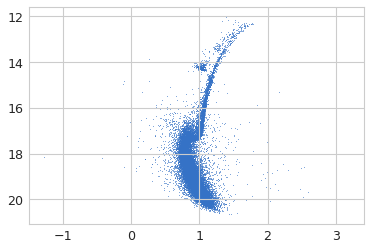

In [45]:
G_RP = gaia_data['phot_rp_mean_mag']
G_BP = gaia_data['phot_bp_mean_mag']
print(G_BP - G_RP)
plt.gca().invert_yaxis()
plt.scatter(G_BP-G_RP , G_BP, s = 0.5)
plt.show()

In [59]:
hola = [1,2,3,45,5]
hola_np = np.asarray(hola)
mean_val = np.mean(hola_np)
print(mean_val, type(mean_val))

11.2 <class 'numpy.float64'>
